In [1]:
!python rf.py -tr spam.train.txt -te spam.test.txt

Figure(800x800)
             precision    recall  f1-score   support

        0.0    0.50992   0.83473   0.63309      2033
        1.0    0.95006   0.79671   0.86665      8023

avg / total    0.86108   0.80440   0.81943     10056
final score    0.72999   0.81572   0.74987     10056



#### 2. Сравнить RF c другими известными алгоритмами классификации.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as pl

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


args_train = 'spam.train.txt'
args_test = 'spam.test.txt'
train_data = np.loadtxt(args_train)
test_data  = np.loadtxt(args_test)

clfs = [RandomForestClassifier(random_state=1337), KNeighborsClassifier(), 
        RidgeClassifier(), LogisticRegression(max_iter=1000),
        SVC(random_state=1337), DecisionTreeClassifier(random_state=1337)]

In [3]:
train_x, train_y = train_data[0::, 1::], train_data[0::, 0]
test_x, test_y = test_data[0::, 1::], test_data[0::, 0]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((7093, 102), (7093,), (10056, 102), (10056,))

In [4]:
from tqdm import tqdm
from sklearn.utils import shuffle

scores = dict()
for clf in tqdm(clfs):
    scores[clf.__class__.__name__] = []

shuffle_times = 10
for _ in range(shuffle_times):
    shuffled_train_x, shuffled_train_y = shuffle(train_x, train_y, random_state=1337)
    for clf in tqdm(clfs):
        current_scores = cross_val_score(clf, shuffled_train_x, 
                                         shuffled_train_y, cv=10, scoring='f1')
        scores[clf.__class__.__name__] += [current_scores]

100%|██████████| 6/6 [00:54<00:00,  9.01s/it]


In [5]:
from scipy.stats import wilcoxon
scores_list = list(scores.items())

for score_other_clf in tqdm(scores_list[1:]):
    # since list of tuples (clf_name, [cv_scores])
    #  scores_list[i][1][k] - scores of i-th clf on k-th shuffle
    p_values = []
    for k in range(shuffle_times):
        stat_test = wilcoxon(scores_list[0][1][k], score_other_clf[1][k], alternative='greater')
        p_values.append(stat_test.pvalue)
    med = np.median(p_values)
    print('H1: RandomForest score greater than', score_other_clf[0], 'score:')
    #print(p_values)
    print('  Median p_value in wilcoxon test RForest vs', score_other_clf[0], med)
    if med < 0.05:
        print('    Difference statistically significant, reject H0')
    else:
        print('    There is no evidence to reject H0')

  0%|          | 0/5 [00:00<?, ?it/s]/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
100%|██████████| 5/5 [00:00<00:00, 284.58it/s]

H1: RandomForest score greater than KNeighborsClassifier score:
  Median p_value in wilcoxon test RForest vs KNeighborsClassifier 0.0009765625
    Difference statistically significant, reject H0
H1: RandomForest score greater than RidgeClassifier score:
  Median p_value in wilcoxon test RForest vs RidgeClassifier 0.0009765625
    Difference statistically significant, reject H0
H1: RandomForest score greater than LogisticRegression score:
  Median p_value in wilcoxon test RForest vs LogisticRegression 0.0009765625
    Difference statistically significant, reject H0
H1: RandomForest score greater than SVC score:
  Median p_value in wilcoxon test RForest vs SVC 0.1871296596401122
    There is no evidence to reject H0
H1: RandomForest score greater than DecisionTreeClassifier score:
  Median p_value in wilcoxon test RForest vs DecisionTreeClassifier 0.0009765625
    Difference statistically significant, reject H0


- Про различия в точности RandomForest и SVM ничего сказать нельзя
- Различия в точности RandomForest и остальных классификаторов - определенно статистически значимы в пользу RandomForest


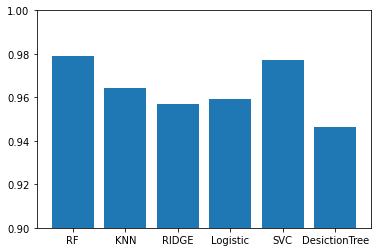

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


whole_mean_scores = []
names = ['RF', 'KNN', 'RIDGE', 'Logistic', 'SVC', 'DesictionTree']
for estimator_idx in range(len(names)):
    whole_mean_scores.append(np.array([scores_list[estimator_idx][1][k].mean() for k in range(shuffle_times)]).mean())
plt.bar(names, whole_mean_scores)
plt.ylim(0.9, 1)
plt.show()

 #### 3. Написать функцию, подбирающую параметры числа деревьев и процента признаков в деревьях. Построить график

In [8]:
trees_param = np.arange(10, 150, 10)
features_percent_param = np.linspace(0, 1, 10)

def find_params(x_train, x_test):
    x_train_sh, x_test_sh = shuffle(x_train, x_test)
    number_of_features = x_train.shape[1]
    # fit n_estimators
    stats = [[], []]
    current_score = 0
    optimal_n_estimators = 0
    for n_trees in trees_param:
        clf = RandomForestClassifier(n_estimators=n_trees)
        current_score = cross_val_score(clf, x_train_sh, x_test_sh, cv=10, scoring='f1').mean()
        stats[0].append([n_trees])
        stats[1].append([current_score])
        print('n_estimators: {}, score: {}'.format(n_trees, current_score))
        prev_score = current_score
    optimal_n_estimators = trees_param[np.argmax(stats[1])]
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.xlabel('n_estimators')
    plt.ylabel('cross_val_score')
    plt.plot(stats[0], stats[1])

    current_score = max_score = 0
    stats = [[], []]
    for percent in features_percent_param[1:]:
        use_features_in_tree = (int)(percent * number_of_features)
        clf = RandomForestClassifier(n_estimators=optimal_n_estimators,
                                     max_features=use_features_in_tree)
        current_score = cross_val_score(clf, x_train_sh, x_test_sh, cv=10).mean()
        print('use_features_in_tree (num): {}, score: {}'.format(use_features_in_tree, current_score))
        stats[0].append([percent])
        stats[1].append([current_score])
        if current_score > max_score:
            max_score = current_score
            optimal_feature_percent = percent
    plt.subplot(1,2,2)
    plt.xlabel('feature_percent')
    plt.ylabel('cross_val_score')
    plt.plot(stats[0], stats[1])
    plt.show()
    return optimal_n_estimators, optimal_feature_percent

n_estimators: 10, score: 0.9716938582465244
n_estimators: 20, score: 0.9750521137466708
n_estimators: 30, score: 0.9762203307839149
n_estimators: 40, score: 0.9766975622582652
n_estimators: 50, score: 0.9796057185863074
n_estimators: 60, score: 0.9781506016448566
n_estimators: 70, score: 0.9786399668384209
n_estimators: 80, score: 0.979021155845496
n_estimators: 90, score: 0.979035561890587
n_estimators: 100, score: 0.9781515616905676
n_estimators: 110, score: 0.9789143106411167
n_estimators: 120, score: 0.9786416052568077
n_estimators: 130, score: 0.9784078147771652
n_estimators: 140, score: 0.9797381494853263
use_features_in_tree (num): 11, score: 0.9770200043703688
use_features_in_tree (num): 22, score: 0.976596078587179
use_features_in_tree (num): 34, score: 0.9754693180237985
use_features_in_tree (num): 45, score: 0.9756099644410895
use_features_in_tree (num): 56, score: 0.9736357496175927
use_features_in_tree (num): 68, score: 0.9722263056477086
use_features_in_tree (num): 79, sc

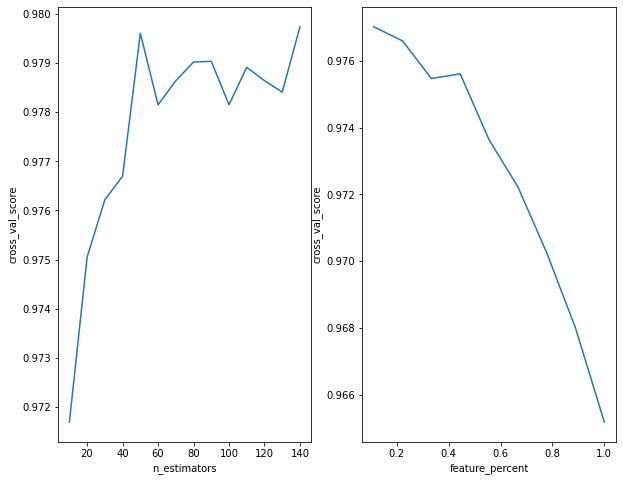

In [9]:
optimal_n_estimators, optimal_feature_percent = find_params(train_x, train_y)

#### 4. Почему качество классификации для класса spam выше, чем для класса notspam?
- Классы несбалансированы: примеров спама больше, чем неспама, что может повлиять на f1 меру для класса, представленного в меньшинстве.

In [10]:
np.unique(train_y, return_counts=True), np.unique(test_y, return_counts=True)

((array([0., 1.]), array([2970, 4123])),
 (array([0., 1.]), array([2033, 8023])))

In [11]:
optimal_feature_percent, optimal_n_estimators

(0.1111111111111111, 140)

In [13]:
from rf import classification_report
optimal_feature_percent = 0.1111
optimal_n_estimators = 140
number_of_features = train_x.shape[1]


from sklearn.metrics import f1_score
use_features_in_tree = (int)(optimal_feature_percent * number_of_features)
clf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_features=use_features_in_tree)
clf.fit(train_x, train_y)
print(classification_report(test_y, clf.predict(test_x)))

             precision    recall  f1-score   support

        0.0    0.80721   0.94737   0.87169      2033
        1.0    0.98605   0.94266   0.96387      8023

avg / total    0.94989   0.94362   0.94523     10056
final score    0.89663   0.94502   0.91778     10056

